In [375]:
import pandas as pd
import numpy as np
import json

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix,
                             precision_recall_curve)

In [165]:
data = pd.read_csv('attrition_train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 31 columns):
Age                         1176 non-null int64
Attrition                   1176 non-null int64
BusinessTravel              1176 non-null object
DailyRate                   1176 non-null int64
Department                  1176 non-null object
DistanceFromHome            1176 non-null int64
Education                   1176 non-null int64
EducationField              1176 non-null object
EnvironmentSatisfaction     1176 non-null int64
Gender                      1176 non-null int64
HourlyRate                  1176 non-null int64
JobInvolvement              1176 non-null int64
JobLevel                    1176 non-null int64
JobRole                     1176 non-null object
JobSatisfaction             1176 non-null int64
MaritalStatus               1176 non-null object
MonthlyIncome               1176 non-null int64
MonthlyRate                 1176 non-null int64
NumCompaniesWorked      

In [421]:
with open('categorical_variable_values.json', 'r') as f:
    cat_values_dict = json.load(f)
cat_values_dict

{'BusinessTravel': ['Travel_Rarely', 'Non-Travel', 'Travel_Frequently'],
 'Department': ['Research & Development', 'Sales', 'Human Resources'],
 'MaritalStatus': ['Married', 'Divorced', 'Single'],
 'EducationField': ['Other',
  'Technical Degree',
  'Life Sciences',
  'Marketing',
  'Medical',
  'Human Resources'],
 'JobRole': ['Research Director',
  'Laboratory Technician',
  'Healthcare Representative',
  'Sales Executive',
  'Research Scientist',
  'Manufacturing Director',
  'Sales Representative',
  'Manager',
  'Human Resources']}

## Processing training dataset

In [424]:
num_orig_cols = data.shape[1] - len(cat_values_dict)
num_enc_cols = sum([len(cats) for cats in cat_values_dict.values()])
print(num_orig_cols, num_enc_cols)

26 24


In [382]:
X = np.zeros(shape=(data.shape[0], num_orig_cols+num_enc_cols-1))

mask = [(each not in cat_values_dict and each != 'Attrition') for each in data.columns]
X[:, :num_orig_cols-1] = data.loc[:, data.columns[mask]]

In [383]:
cat_cols = list(cat_values_dict.keys())
cat_values = [cat_values_dict[col] for col in data[cat_cols].columns]

ohe = OneHotEncoder(categories=cat_values, sparse=False, )

X[:, num_orig_cols-1:] = ohe.fit_transform(X=data[cat_cols])
y = data.Attrition.values

In [384]:
print(X.shape)
print(y.shape)

(1176, 49)
(1176,)


## Modelling

In [212]:
meta_gbc = GradientBoostingClassifier()

param_dist = {
    'n_estimators': list(range(10, 210, 10)),
    'criterion': ['mae', 'mse'],
    'max_features': ['sqrt', 'log2', 0.25, 0.3, 0.5, 0.8, None],
    'max_depth': list(range(1, 10)),
    'min_samples_leaf': list(range(1, 10))
}

In [264]:
rand_search_params = {
    'param_distributions': param_dist,
    'scoring': 'accuracy',
    'n_iter': 100,
    'cv': 5,
    'return_train_score': True,
    'n_jobs': -1,
    'random_state': 11
}
random_search = RandomizedSearchCV(meta_gbc, **rand_search_params)
random_search.fit(X, y)

CPU times: user 2.03 s, sys: 546 ms, total: 2.58 s
Wall time: 8min 15s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'criterion': ['mae', 'mse'], 'max_features': ['sqrt', 'log2', 0.25, 0.3, 0.5, 0.8, None], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
          pre_dispatch='2*n_jobs', random_state=11, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

In [385]:
idx = np.argmax(random_search.cv_results_['mean_test_score'])
final_params = random_search.cv_results_['params'][idx]
final_params

{'n_estimators': 180,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 2,
 'criterion': 'mse'}

In [425]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.15, random_state=11)
train_X.shape, train_y.shape, val_X.shape, val_y.shape

((999, 49), (999,), (177, 49), (177,))

In [426]:
gbc = GradientBoostingClassifier(**final_params)
gbc.fit(train_X, train_y)

preds_train = gbc.predict(train_X)
preds_val = gbc.predict(val_X)
pred_probs_val = np.array([each[1] for each in gbc.predict_proba(val_X)])

In [427]:
print('train accuracy_score = {}'.format(accuracy_score(y_true=train_y, y_pred=preds_train)))
print('validation accuracy_score = {}'.format(accuracy_score(y_true=val_y, y_pred=preds_val)))

print('confusion_matrix: \n{}'.format(confusion_matrix(y_true=val_y, y_pred=preds_val)))
print('precision_score = {}'.format(precision_score(y_true=val_y, y_pred=preds_val)))
print('recall_score = {}'.format(recall_score(y_true=val_y, y_pred=preds_val)))

train accuracy_score = 0.9319319319319319
validation accuracy_score = 0.8587570621468926
confusion_matrix: 
[[146   0]
 [ 25   6]]
precision_score = 1.0
recall_score = 0.1935483870967742


In [436]:
threshold = 0.1
preds_val = (pred_probs_val > threshold).astype(int)

print('confusion_matrix: \n{}'.format(confusion_matrix(y_true=val_y, y_pred=preds_val)))
print('precision_score = {}'.format(precision_score(y_true=val_y, y_pred=preds_val)))
print('recall_score = {}'.format(recall_score(y_true=val_y, y_pred=preds_val)))

confusion_matrix: 
[[98 48]
 [ 4 27]]
precision_score = 0.36
recall_score = 0.8709677419354839


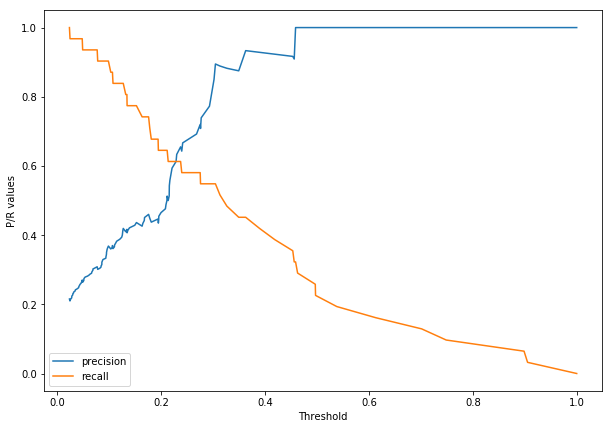

In [451]:
precision, recall, thresholds = precision_recall_curve(val_y, pred_probs_val)
PR_variation_df = pd.DataFrame({'precision': precision, 'recall': recall}, index=list(thresholds)+[1])

PR_variation_df.plot(figsize=(10,7))
plt.xlabel('Threshold')
plt.ylabel('P/R values')
plt.show()

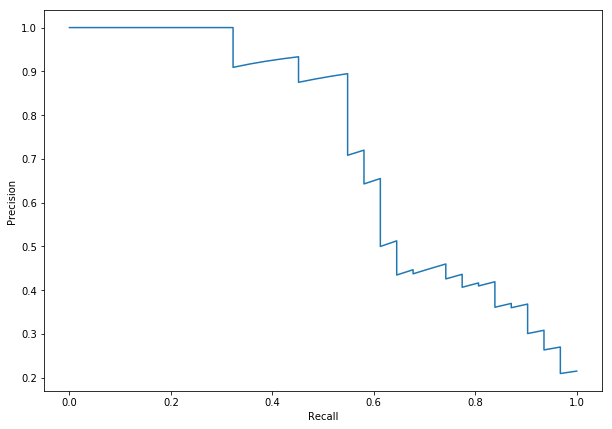

In [437]:
plt.figure(figsize=(10,7))

plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [452]:
final_threshold = 0.3

## Reading & processing test dataset

In [456]:
test = pd.read_csv('attrition_test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 30 columns):
Age                         294 non-null int64
BusinessTravel              294 non-null object
DailyRate                   294 non-null int64
Department                  294 non-null object
DistanceFromHome            294 non-null int64
Education                   294 non-null int64
EducationField              294 non-null object
EnvironmentSatisfaction     294 non-null int64
Gender                      294 non-null int64
HourlyRate                  294 non-null int64
JobInvolvement              294 non-null int64
JobLevel                    294 non-null int64
JobRole                     294 non-null object
JobSatisfaction             294 non-null int64
MaritalStatus               294 non-null object
MonthlyIncome               294 non-null int64
MonthlyRate                 294 non-null int64
NumCompaniesWorked          294 non-null int64
OverTime                    294 non-null int

In [466]:
num_orig_cols = test.shape[1] - len(cat_values_dict)
num_enc_cols = sum([len(cats) for cats in cat_values_dict.values()])
print(num_orig_cols, num_enc_cols)

25 24


In [467]:
test_X = np.zeros(shape=(test.shape[0], num_orig_cols+num_enc_cols))

mask = [(each not in cat_values_dict) for each in test.columns]
test_X[:, :num_orig_cols] = test.loc[:, test.columns[mask]]

In [469]:
cat_cols = list(cat_values_dict.keys())
cat_values = [cat_values_dict[col] for col in test[cat_cols].columns]

ohe = OneHotEncoder(categories=cat_values, sparse=False, )

test_X[:, num_orig_cols:] = ohe.fit_transform(X=test[cat_cols])
print(test_X.shape)

(294, 49)


## Predicting on test dataset

In [470]:
pred_probs_test = np.array([each[1] for each in gbc.predict_proba(test_X)])
preds_test = (pred_probs_test > final_threshold).astype(int)

In [480]:
with open('final_predictions.csv', 'w') as f:
    f.writelines([str(val)+'\n' for val in preds_test])